This is a classic problem of *Classification* that is very similar to the **MNIST** digit recognition problem with the exception that this problem comprises of 5 classes whereas **MNIST** has 10 classes. As this is a image-based problem one good approach is to build a Convolutional Neural Network (CNN). (We can go for SVM with a softmax loss, but this is better)

# 1. INTRODUCTION

In [1]:
#Importing all the necessary packages
import numpy as np   # Python's library to deal with Scientific computation. It is famous for its efficiency and speed
import pandas as pd   # Python's library to deal with data cleaning and handling
import matplotlib.pyplot as plt   # Python's library for Visualization
from sklearn.preprocessing import OneHotEncoder   # To convert the numeric class labels into one-hot vectors
import cv2   # Advanced "Image Processing" library for Python
import os   # For changing the current working directory and for file handling
from sklearn.metrics import confusion_matrix, classification_report   # Metrics useful for evaluating our model
from sklearn.utils import shuffle   # To shuffle the dataset randomly in-place to avoid any possible bias
from keras.models import Sequential   # Choosing 'Sequential model' from the available two types of models
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten   # Other important components for building the network
###from keras.optimizers import RMSprop   # Discarded RMSprop as 'Adam' was performing better
###from keras.callbacks import ReduceLROnPlateau   # I felt no need for reducing the learning rate constantly over the iterations as, the model converged pretty quickly and there were no saddle points
import warnings   # To ignore package deprecation warnings, etc.;

# To plot the graphs, figures in the notebook itself and not in separate windows
%matplotlib inline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#Turn de-bugging mode 'ON' or 'OFF'
DEBUG = True

In [3]:
#Storing the paths of both the training and test sets in respective variables
training_set_path = './/Train_val//'
test_set_path = './/Test//'

In [4]:
#Storing the list of all character classes
character_classes = [folder_name.split('_')[2] for folder_name in sorted(os.listdir(training_set_path))]

In [5]:
if DEBUG:
    print(character_classes)

['ka', 'kha', 'ga', 'gha', 'kna']


# 2. PRE-PROCESSING

## 2.1 Training Data Creation

In [6]:
#Changing the path the working directory to the location where the training data is present
os.chdir(training_set_path)

In [7]:
#Iterating through all the character folders and buliding a training set and its corresponding class labels
images = []
classes = []
for class_number, character_folder in enumerate(sorted(os.listdir())):
    os.chdir('.//' + character_folder + '//')
    for image in sorted(os.listdir()):
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)   # Converting the color image (3 channels) into grayscale image (1 channel)
        height, width = img.shape
        reshaped_img_vector = img.reshape(height * width)   # Flatten the image into a long single vector
        images.append(reshaped_img_vector)
        classes.append(class_number)
    os.chdir('.//..//')

In [8]:
#Returning to the Home directory where the Jupyter notebook is present
os.chdir('.//..//')

## 2.2 Test Data Creation

In [9]:
#Changing the path the working directory to the location where the test data is present
os.chdir(test_set_path)

In [10]:
#Iterating through all the character folders and buliding a test set and its corresponding class labels
images = []
classes = []
for class_number, character_folder in enumerate(sorted(os.listdir())):
    os.chdir('.//' + character_folder + '//')
    for image in sorted(os.listdir()):
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)   # Converting the color image (3 channels) into grayscale image (1 channel)
        height, width = img.shape
        reshaped_img_vector = img.reshape(height * width)   # Flatten the image into a long single vector
        images.append(reshaped_img_vector)
        classes.append(class_number)
    os.chdir('.//..//')

In [11]:
#Returning to the Home directory where the Jupyter notebook is present
os.chdir('.//..//')

## 2.4 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover, the CNN converges faster on [0..1] data than on [0..255]. (The minimum intensity value is '0' and maximum intensity value is '256')

### 2.4 (a)  Normalizing training data

In [12]:
#Normalizing the image intensity values to be in the range of 0 - 1 (Because, there is no need for 3 channels as the images are mostly in black & white and it also helps for easy computation when passed through neural network)
X_train = np.array(images) / 255.0
X_train = X_train.reshape(-1, 32, 32, 1)   # Reshape the 1024 x 1 vector back to 32 x 32 image so as to pass to CNN. '-1' indicates that it is to be replaced with the "total number of samples"

In [13]:
y_train = np.array(classes)
y_train = y_train.reshape(y_train.shape[0], 1)

In [14]:
#Shuffling the training set in order to avoid bias during training
X_train, y_train = shuffle(X_train, y_train, random_state=0)

### 2.4 (b)  Normalizing test data

In [15]:
#Normalizing the image intensity values to be in the range of 0 - 1 (Because, there is no need for 3 channels as the images are mostly in black & white and it also helps for easy computation when passed through neural network)
X_test = np.array(images) / 255.0
X_test = X_test.reshape(-1, 32, 32, 1)   # Reshape the 1024 x 1 vector back to 32 x 32 image so as to pass to CNN. '-1' indicates that it is to be replaced with the "total number of samples"

In [16]:
y_test = np.array(classes)
y_test = y_test.reshape(y_test.shape[0], 1)

In [17]:
#Shuffling the test set in order to avoid bias during class prediction
X_test, y_test = shuffle(X_test, y_test, random_state=0)

## 2.4 Check for NULL and MISSING values

Null and missing values occur if any of the images is/are corrupted. So, check for any null and missing values as this may affect the model's performance.

In [18]:
#Check for null or missing values in the training set
pd.DataFrame.from_records(X_train).isnull().any().describe()

count        32
unique        1
top       False
freq         32
dtype: object

In [19]:
#Check for null or missing values in the test set
pd.DataFrame.from_records(X_test).isnull().any().describe()

count        32
unique        1
top       False
freq         32
dtype: object

## 2.5 One-Hot encoding

Problem with label encoding (or numeric encoding) is that, it **assumes** *higher* the categorical value, *better* the category.

In [20]:
#One-hot encoding training set labels
onehot_encoder = OneHotEncoder(sparse=False)   # Setting 'sparse' argument to "False" to avoiding problems when using Keras
y_train_encoded = onehot_encoder.fit_transform(y_train)

#One-hot encoding test set labels   (NOT REQUIRED as, we are predicting these values based on the probabilities that are obtained from the 'Softmax' funtion)
###onehot_encoder = OneHotEncoder(sparse=False)   # Setting 'sparse' argument to "False" to avoiding problems when using Keras
###y_test_encoded = onehot_encoder.fit_transform(y_test)

## 2.6 Validation set creation

Validation set is used because we can perform hyperparameter tuning and also choose the right model for the problem under consideration. This also ensures that we do not perform parameter tuning during the time of testing and thus the testing will be un-biased.

* Popular **train-validation-test** splits are 70-20-10, 60-20-20, 95-2.5-2.5, 99-0.5-0.5, etc.;

In [21]:
#Randomly choosing 33% of the training samples to be the cross-validation (or) hold-out set
num_values = int(0.33 * X_train.shape[0])
random_samples = np.random.permutation(X_train.shape[0])[:num_values]

X_val = X_train[random_samples]
y_val = y_train_encoded[random_samples]

#Deleting the previously chosen random samples from our training set along the row (axis=0)
X_train = np.delete(X_train, random_samples, axis=0)
y_train_encoded = np.delete(y_train_encoded, random_samples, axis=0)

In [22]:
X_train.shape, X_val.shape

((1005, 32, 32, 1), (495, 32, 32, 1))

# 3. UNDERSTANDING THE DATASET

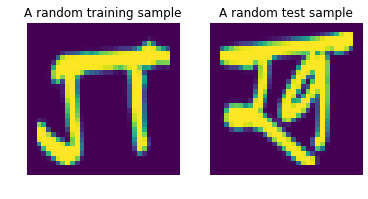

In [23]:
if DEBUG:
    _, ax = plt.subplots(1, 2)
    ax[0].axis('off')
    #A random training data sample
    ax[0].imshow(X_train[np.random.randint(X_train.shape[0])].reshape(32, 32))
    ax[0].set_title('A random training sample')

    ax[1].axis('off')
    #A random test data sample
    ax[1].imshow(X_test[np.random.randint(X_test.shape[0])].reshape(32, 32))
    ax[1].set_title('A random test sample')

In [24]:
if DEBUG:
    #Getting to know about the data more...
    num_of_train_samples = X_train.shape[0]
    num_of_val_samples = X_val.shape[0]
    num_of_test_samples = X_test.shape[0]
    num_classes = len(np.unique(y_train))

    print("The training set is of shape : ", X_train.shape)
    print("The training labels vector is of shape : ", y_train_encoded.shape)
    print()
    print("The validation set is of shape : ", X_val.shape)
    print("The validation labels vector is of shape : ", y_val.shape)
    print()
    print("The test set is of shape : ", X_test.shape)
    print("The test labels vector is of shape : ", y_test.shape)
    print("\n")
    print("There are " + str(num_of_train_samples) + " training, " + str(num_of_val_samples) + " validation and " + str(num_of_test_samples) + " test samples respectively.")
    print("The total number of classes are :- ", num_classes)

The training set is of shape :  (1005, 32, 32, 1)
The training labels vector is of shape :  (1005, 5)

The validation set is of shape :  (495, 32, 32, 1)
The validation labels vector is of shape :  (495, 5)

The test set is of shape :  (1500, 32, 32, 1)
The test labels vector is of shape :  (1500, 1)


There are 1005 training, 495 validation and 1500 test samples respectively.
The total number of classes are :-  5


# 4. CNN MODEL

CNN architechture is **Input -> [ [ Conv2D -> ReLU] * 2 -> MaxPool2D -> Dropout ] * 2 -> Flatten -> Dense -> Dropout -> Output**

In [25]:
#Creating the model architecture
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation ='relu', input_shape = (32, 32, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

In [26]:
#Define the optimizer
###optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [27]:
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
#Set a learning rate annealer
###learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [29]:
### epochs = 30
### batch_size = 128
epochs = 15
batch_size = 64

In [30]:
history = model.fit(X_train, y_train_encoded, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), verbose = 2)

Train on 1005 samples, validate on 495 samples
Epoch 1/15
 - 6s - loss: 1.3995 - acc: 0.4398 - val_loss: 0.6863 - val_acc: 0.7455
Epoch 2/15
 - 6s - loss: 0.6861 - acc: 0.7682 - val_loss: 0.3043 - val_acc: 0.8788
Epoch 3/15
 - 6s - loss: 0.3419 - acc: 0.8836 - val_loss: 0.1584 - val_acc: 0.9495
Epoch 4/15
 - 6s - loss: 0.1604 - acc: 0.9453 - val_loss: 0.0939 - val_acc: 0.9636
Epoch 5/15
 - 6s - loss: 0.1359 - acc: 0.9483 - val_loss: 0.0686 - val_acc: 0.9636
Epoch 6/15
 - 6s - loss: 0.0807 - acc: 0.9771 - val_loss: 0.0377 - val_acc: 0.9879
Epoch 7/15
 - 6s - loss: 0.0486 - acc: 0.9831 - val_loss: 0.0259 - val_acc: 0.9879
Epoch 8/15
 - 6s - loss: 0.0483 - acc: 0.9781 - val_loss: 0.0333 - val_acc: 0.9899
Epoch 9/15
 - 6s - loss: 0.0395 - acc: 0.9861 - val_loss: 0.0423 - val_acc: 0.9899
Epoch 10/15
 - 6s - loss: 0.0390 - acc: 0.9891 - val_loss: 0.0260 - val_acc: 0.9939
Epoch 11/15
 - 6s - loss: 0.0270 - acc: 0.9920 - val_loss: 0.0266 - val_acc: 0.9919
Epoch 12/15
 - 6s - loss: 0.0220 - acc

# 5. EVALUATE THE MODEL

We've now trained our model (above) and let's proceed onto validating it and tuning the network

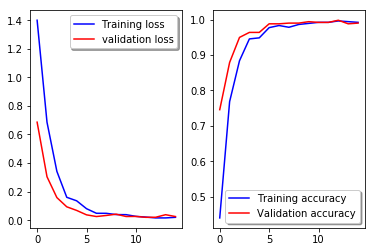

In [31]:
#Plot the loss and accuracy curves for training and validation sets
if DEBUG:
    ###   LOSS CURVE   ###
    _, ax = plt.subplots(1, 2)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
    legend = ax[0].legend(loc='best', shadow=True)

    ###   ACCURACY CURVE   ###
    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

# 6. PREDICTING THE CLASS LABELS OF THE TEST DATA

It is time to test the model we built above to **new images** (that it has never seen before !!!)

In [32]:
#Collecting the class probabilities that are obtained from the 'Softmax' function
predictions = model.predict_on_batch(X_test)

In [33]:
#Considering only the class with maximum 'class probability' as this is our "Predicted Class"
predicted_classes = predictions.argmax(axis=1)   # Returns the index with the maximum value along each row

In [34]:
if DEBUG:
    predicted_classes   # 0 - 'ka', 1 - 'kha', 2 - 'ga', 3 - 'gha', 4 - 'kna'

# 7. EVALUATION METRICS

### 7.1 Confusion Matrix

Check the distribution of currently and incorrectly classified labels across all classes

In [35]:
matrix = confusion_matrix(y_test, predicted_classes)
print(matrix)

[[300   0   0   0   0]
 [  0 299   1   0   0]
 [  0   0 300   0   0]
 [  0   0   2 298   0]
 [  0   1   0   1 298]]


### 7.2 Classification Report

Generate a report on Precision-Recall, F1-score, etc.; for our data

In [36]:
report = classification_report(y_test, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       0.99      1.00      1.00       300
           3       1.00      0.99      0.99       300
           4       1.00      0.99      1.00       300

   micro avg       1.00      1.00      1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

